# Avaliação em holdouts - Palco 2010 - Measure recommendations variations

from the notebook `Avaliacao de Holdouts - sample Palco 2010 ISGD - 10 last examples`, the highest performance obtained comes from:
* Exp7: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket

# Import stuff

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Read Data

In [4]:
# importa dataset 'palco playlists'
data = pd.read_csv('output/palco_2010_dump/sampled_palco2010.csv')
user_col = 'user_id'
item_col = 'track_id'

### Convert timestamp

In [5]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 2.53 s, sys: 27.7 ms, total: 2.56 s
Wall time: 2.56 s


# Hyperparameters

In [7]:
# define hyperparameters
num_factors = 200
num_iter = 6
learn_rate = 0.35
regularization = 0.5
num_nodes = 8

# Experiment 7

In [8]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []
frequent_users_list = [] # store frequent users in each bucket to compare recommendations made to them
for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            if u not in frequent_users_list:
                frequent_users_list.append(u)
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        # buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)
        buckets[i] = b.reset_index(drop=True)

Creating buckets. . .
Creating holdouts. . .


In [9]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [10]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [11]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [12]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=10, exclude_known_items=False, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 5100
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 6500
Test Holdout 3
recommendations not made for users in holdout 3 x checkpoint 0: 7600
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 4340
Test Holdout 3
recommendations not made for users in holdout 3 x checkpoint 1: 6030
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
Test Holdout 3
recommendations not made for users in holdout 3 x checkpoint 2: 4070
----------------------------------------------------------

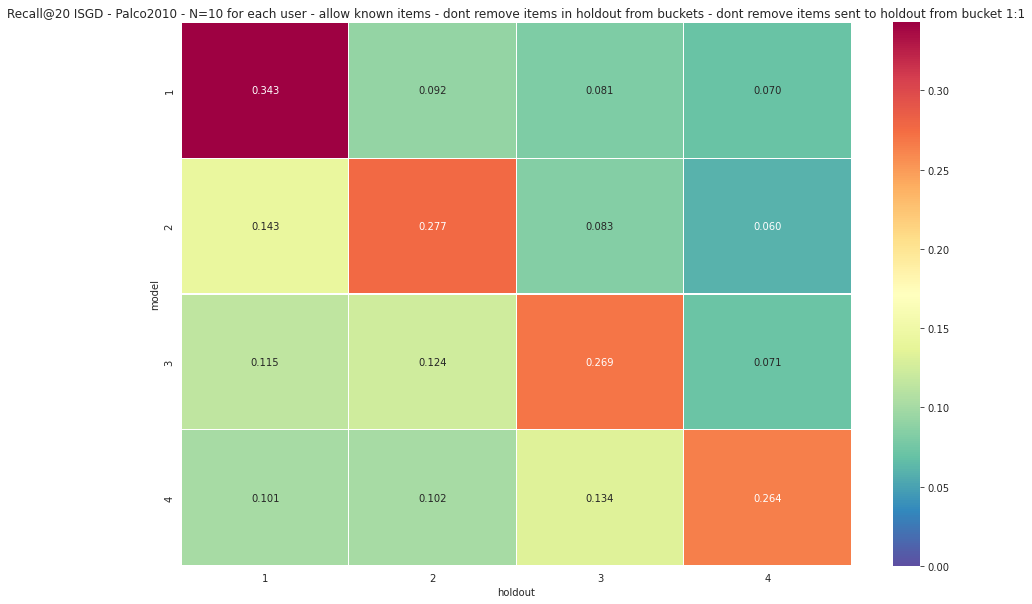

In [13]:
rm = eval.results_matrix
df_exp7 = pd.DataFrame(rm)
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp7,
    round_point=3,
    title='Recall@20 ISGD - Palco2010 - N=10 for each user - allow known items - dont remove items in holdout from buckets - dont remove items sent to holdout from bucket 1:1',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [14]:
arecall = avg_recall(df_exp7)
arecall

0.28840415575013534

In [15]:
BWT, meanBWT = compute_BWT(df_exp7)
BWT, meanBWT

([-0.19999999999999998, -0.19019033462188434, -0.18427024537094058],
 -0.1914868599976083)

In [16]:
FWT = compute_FWT(df_exp7)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0761871174322336

# Comparing recommendations

In [24]:
# import time
from eval_implicit import EvalHoldout

def recommend_to_freq_users(
    model,
    buckets,
    frequent_users_list,
    N_recommendations=20,
    exclude_known_items:bool=True,
    default_user:str='none',
    verbose=True):    
    '''
    Incremental training of recommendation model.
    '''
    recommendations_dict = {u:{} for u in frequent_users_list}
    for b, bucket in enumerate(buckets):
        if verbose:
            print(100*'-')
            print(f'Train bucket {b}')
        # incrtrain_time = []            
        for i in range(bucket.size):
            uid, iid = bucket.GetTuple(i) # get external IDs
            model.IncrTrain(uid, iid) # perform incremental training

        # after training a bucket - recommend items to frequent users
        if b >= cold_start_buckets:
            for uid in frequent_users_list:
                reclist = model.Recommend(user = uid, n = N_recommendations, exclude_known_items = exclude_known_items, default_user=default_user)
                if len(reclist):
                    recommendations_dict[uid][b] = reclist[:N_recommendations,0]
                else:
                    recommendations_dict[uid][b] = []
    return recommendations_dict

In [25]:
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [26]:
recommendations_dict = recommend_to_freq_users(
        model=model,
        buckets=buckets,
        frequent_users_list=frequent_users_list,
        N_recommendations=10,
        exclude_known_items=False,
        default_user='none',
        verbose=True)

joblib.dump(recommendations_dict, 'rec_dict.joblib')

----------------------------------------------------------------------------------------------------
Train bucket 0
[[2.72030000e+04 5.00000000e-01]
 [2.72010000e+04 5.00000000e-01]
 [6.94400000e+03 5.00000000e-01]
 [2.72020000e+04 5.00000000e-01]
 [3.43090000e+04 8.61080964e-01]
 [3.09080000e+04 8.63745021e-01]
 [3.25110000e+04 8.75687763e-01]
 [3.10100000e+04 8.84641152e-01]
 [3.87160000e+04 8.86058700e-01]
 [3.83870000e+04 8.87392048e-01]]
[[3.53280000e+04 5.17234601e-01]
 [3.26700000e+04 5.57574731e-01]
 [3.46820000e+04 5.76671586e-01]
 [3.70740000e+04 5.77446314e-01]
 [2.74270000e+04 5.77712318e-01]
 [2.85320000e+04 5.78020221e-01]
 [3.33760000e+04 5.78066659e-01]
 [3.57890000e+04 5.78312363e-01]
 [2.53300000e+03 5.78339206e-01]
 [3.51120000e+04 5.78766447e-01]]
[[4.09370000e+04 4.98798116e-01]
 [4.08300000e+04 5.07319647e-01]
 [4.09400000e+04 5.12875703e-01]
 [3.13630000e+04 5.47786564e-01]
 [3.49230000e+04 5.50768545e-01]
 [3.86050000e+04 5.51182658e-01]
 [2.24820000e+04 5.51641

In [4]:
import joblib
# from scipy.spatial.distance import jaccard

In [5]:
recommendations_dict = joblib.load('rec_dict.joblib')
users = [user for user in recommendations_dict.keys()]

In [64]:
def compute_jaccard_dissimilarities(users, recommendations_dict, verbose=False):
    n_buckets = len ( recommendations_dict[ list( recommendations_dict.keys() )[0] ].keys() )
    dissimilarities_storage = {}
    for uid in users:
        recs = recommendations_dict[uid]
        for b1 in range(n_buckets):
            if not list(recs[b1]): # if its empty
                continue
            for b2 in range(b1+1, n_buckets):
                if verbose:
                    print('buckets:', b1, b2)    
                dissimilarities_storage.setdefault(str(b1)+str(b2), [])
                if not list(recs[b2]): # if its empty
                    continue
                _a = [ str(_) for _ in recs[b1] ]
                _b = [ str(_) for _ in recs[b2] ]

                intersection = [ia in _b for ia in _a]
                intersection = np.array(_a)[intersection]
                _a_only = [ ia not in intersection for ia in _a ]
                _a_only = np.array(_a)[_a_only]
                _b_only = [ ib not in intersection for ib in _b ]
                _b_only = np.array(_b)[ _b_only ]
                union = list(intersection) + list(_a_only) + list(_b_only)
                jaccard_diss_index = 1 - (len(intersection) / len(union))
                
                if verbose:
                    print ( 'recs_1:', _a )
                    print ( 'recs_2:', _b )
                    print ( 'intersection:', intersection )
                    print ( 'union:', union )
                    print ( 'dissimilarity_index:', jaccard_diss_index )
                    print ( '----' )                

                dissimilarities_storage[str(b1)+str(b2)].append(jaccard_diss_index)
    return dissimilarities_storage

In [79]:
dissimilarities_storage = compute_jaccard_dissimilarities(users, recommendations_dict, verbose=False)
print( 'Mean dissimilarity:' )
pd.Series( {k:np.mean( dissimilarities_storage[k] ) for k in dissimilarities_storage.keys()} )

Mean dissimilarity:


01    0.889692
02    0.936714
03    0.950660
12    0.867281
13    0.920357
23    0.848318
dtype: float64